# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK** 

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


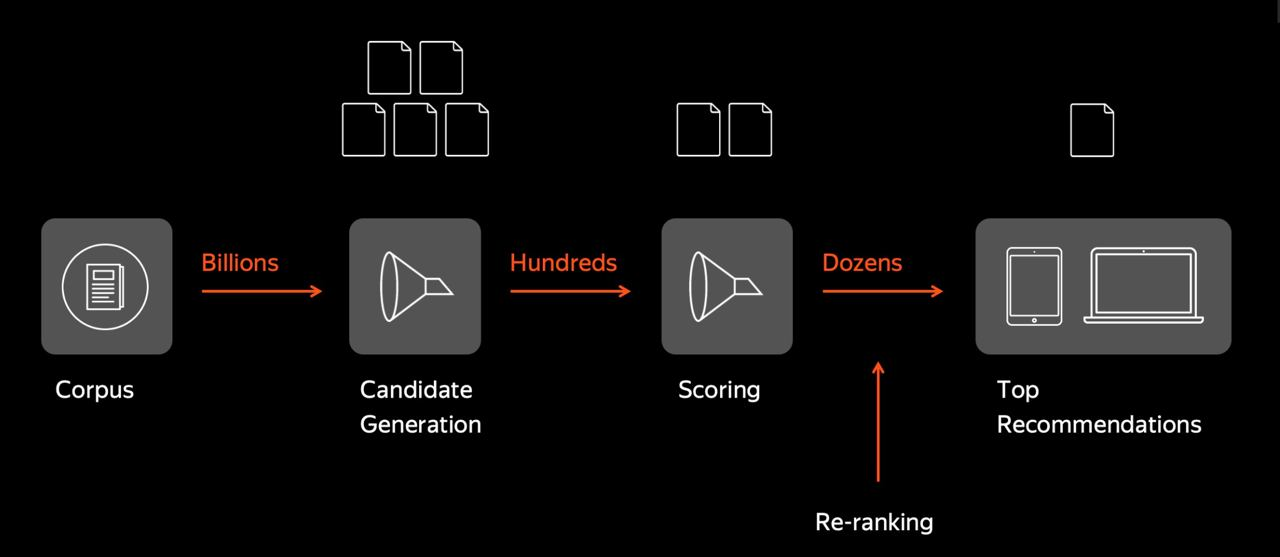

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [10]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    average_precisions = []

    for u in range(len(relevant)):
        relevant_u = relevant[u]
        predicted_u = predicted[u][:k]
        n_u = len(relevant_u)
        relevant_u_set = set(relevant_u)
        ap_u_sum = 0.0
        hits = 0

        for i, p in enumerate(predicted_u):
            #p_u@k
            if p in relevant_u_set:
                hits += 1
                #p_u@(i+1)
                precision_at_i = hits / (i + 1.0)
                ap_u_sum += precision_at_i

        denom = min(k, n_u)
        if denom == 0:
            ap_u = 0.0
        else:
            ap_u = ap_u_sum / denom
        average_precisions.append(ap_u)

    return sum(average_precisions) / len(average_precisions) if average_precisions else 0.0

In [11]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [22]:
from tqdm import tqdm

def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [23]:
train_ratings, test_ratings = train_test_split(ratings)



  0%|          | 0/241 [00:00<?, ?it/s]

100%|██████████| 241/241 [00:00<00:00, 13230.20it/s]

100%|██████████| 241/241 [00:00<00:00, 5217.36it/s]


Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [24]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [25]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [26]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [27]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [28]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [29]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [30]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        rec = [self.recommend(uid) for uid in range(self.n_users)]
        test_preds = self.remove_train_items(rec, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [32]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = ratings.dot(user_vector)
    sum_of_set = ratings.sum(axis=1) + user_vector.sum()
    union = sum_of_set - intersection
    jaccard = np.where(union != 0, intersection / union, 0.0)
    return jaccard

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [53]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        
        self.similarity_func = jaccard
        self.alpha = 0.8

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        sim = self.similarity(user_vector)
        sim[uid] = 0
        sim[sim <= self.alpha] = 0
        predicted_scores = sim.dot(self.R)
        predicted_scores[user_vector.nonzero()] = -np.inf
        return np.argsort(predicted_scores)[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [34]:
class Popular(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.item_popularity = np.sum(self.R, axis=0)
        self.sorted_popular_items = np.argsort(self.item_popularity)[::-1]

    def recommend(self, uid: int):
        return self.sorted_popular_items

In [35]:
class Random(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.all_items = np.arange(self.n_items)
    
    def recommend(self, uid: int):
        np.random.shuffle(self.all_items)
        return self.all_items


In [118]:
user2user_model = User2User(train_ratings)
popular_model = Popular(train_ratings)
random_model = Random(train_ratings)

models = {
    "User2User ": user2user_model,
    "Popular": popular_model,
    "Random": random_model
}

k_values = [2, 5, 10, 15]
map_scores = {name: [] for name in models.keys()}

for k in k_values:
    for name, model in models.items():
        preds = model.get_test_recommendations(k)
        score = mapk(test_relevant, preds, k=k)
        map_scores[name].append(score)

/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


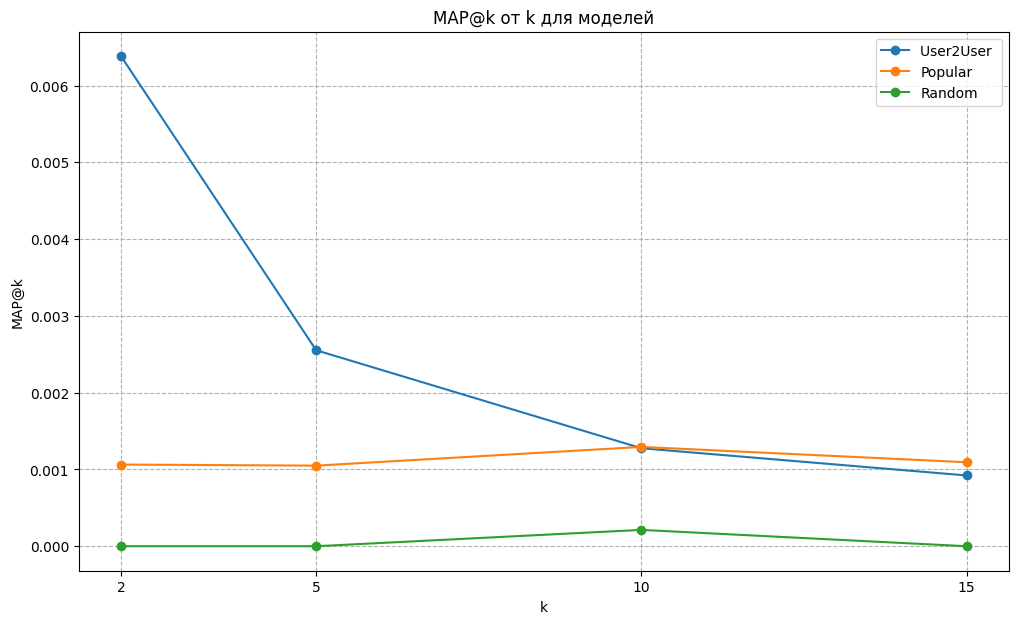

In [119]:
plt.figure(figsize=(12, 7))
for name, scores in map_scores.items():
    plt.plot(k_values, scores, marker='o', linestyle='-', label=name)

plt.title('MAP@k от k для моделей')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.xticks(k_values)
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

*Как можно заметить, вполне ожидаемо рекомендации на основе меры Жаккара получаются наилучшими (хотя и сами значения метрик оставляют желать лучшего). Видно, что модель, рекомендующая популярные треки, перформит достаточно плохо, можно сказать не сильно лучше рандома*

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [73]:
user_id = np.random.randint(0, user2user_model.n_users)

In [74]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
40,LoveGame,['Lady Gaga']
102,Just Dance,"['Lady Gaga', ""Colby O'Donis""]"
137,Umbrella,"['Rihanna', 'Jay-Z']"
225,Rich Girl,"['Gwen Stefani', 'Eve']"
234,Wind Of Change,['Scorpions']
354,Dancing Queen,['ABBA']
581,Gimme! Gimme! Gimme! (A Man After Midnight),['ABBA']
630,Every Breath You Take,['The Police']
726,Say It Right,['Nelly Furtado']
780,Heart-Shaped Box,['Nirvana']


In [75]:
preds = user2user_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


,name,artists
67312,Послала,"['VAVAN', 'Real Girl']"
22480,What A Wonderful World,"['Chris Botti', 'Mark Knopfler']"
22478,In The Beginning,"['Fahrenhaidt', 'Alice Merton']"
22477,Survivor,"['Amit', 'Rani']"
22476,The View,['DRS feat. LSB & Tyler Daley']
22475,Опытная девочка,['АЛ-90']
22474,Brave Men,"['Gramatik', 'Eskobars']"
22473,Bloody Stream,['Coda']
22472,Jojo Sono Chino Sadame,['Hiroaki Tommy Tominaga']
22471,Sakuranoamemoeginoyo,['KOTOKO']


In [76]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
61323,WAP,"['Cardi B', 'Megan Thee Stallion']"
61390,Айсберг,['ssshhhiiittt!']
61560,Втюрилась,['Дора']
61629,M to the B,['Millie B']
61721,Лютики,['просто Лера']
61745,не учи,['кис-кис']
61746,танцуй,['кис-кис']
61747,малолетка,['кис-кис']
61748,игрушка,['кис-кис']
61749,мелочь,['кис-кис']


*Как можно и увидеть по метрикам, получилось прямо сказать не очень, если на нескольких случайных юзеров посмотреть. Иногда что-то попадается адекватное вполне, но точности мало*

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

градиенты функции потерь по параметрам: 

$$\dfrac{\nabla L_{ui}}{\nabla p_{u,k}} = 2(\hat{r}_{ui} - r_{ui})q_{i,k}  + 2 \lambda p_{u,k}$$

$$\dfrac{\nabla L}{\nabla q_{i,k}} = 2(\hat{r}_{ui} - r_{ui})p_{u,k}  + 2 \lambda q_{i,k}$$

**SGD:**

$$p_{u,k} = p_{u,k} - \eta \left(2(\hat{r}_{ui} - r_{ui})q_{i,k}  + 2 \lambda p_{u,k}  \right) $$

$$q_{i,k} = q_{i,k} - \eta  \left(2(\hat{r}_{ui} - r_{ui})p_{u,k}  + 2 \lambda q_{i,k}  \right)  $$
**ALS:**

рассмотрим функцию потерь для конкретного юзера, оптимизируем по $p_u$, $q_i$ константа
$$L_u =  \sum_{i \in I} (p_u^T q_i - r_{ui})^2 + \lambda \|p_u\|^2 \Rightarrow \sum_{i \in I} 2(p_u^T q_i - r_{ui})q_i + 2\lambda p_u = 0 \Rightarrow \sum_{i \in I} (q_i q_i^T)p_u + \lambda I p_u = \sum_{i \in I} r_{ui}q_i$$

$$\left( \sum_{i \in I} q_i q_i^T + \lambda I \right) p_u = \sum_{i \in I} r_{ui}q_i \Rightarrow \mathbf{p_u = \left( \sum_{i \in I} q_i q_i^T + \lambda I \right)^{-1}  \sum_{i \in I} r_{ui}q_i}$$

аналогично можно получить для $q_i$:

$$q_i = \left( \sum_{u \in U} p_u p_u^T + \lambda I \right)^{-1}  \sum_{u \in U} r_{ui}p_u$$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [77]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                u, i = np.where(self.R == 1)
                u, i = np.random.choice(u), np.random.choice(i)
                pu = self.P[u]
                qi = self.Q[i]
                self.P[u] = pu - self.lr * 2 *((pu @ qi - self.R[u, i])* qi + self.lamb * pu)
                self.Q[i] = qi - self.lr * 2 *((pu @ qi - self.R[u, i])* pu + self.lamb * qi)

            elif self.mode == 'als':
                for u in range(self.n_users):
                    i = self.R[u, :].nonzero()[0]
                    Q_u = self.Q[i, :]
                    r_u = self.R[u, i]
                    A = Q_u.T @ Q_u + self.lamb * np.eye(self.dim)
                    b = Q_u.T @ r_u

                    self.P[u, :] = np.linalg.solve(A, b)
                
                for i in range(self.n_items):
                    u = self.R[:, i].nonzero()[0]
                    P_i = self.P[u, :]
                    r_i = self.R[u, i]
                    A = P_i.T @ P_i + self.lamb * np.eye(self.dim)
                    b = P_i.T @ r_i
                    
                    self.Q[i, :] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        
        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [106]:
import optuna
from optuna.trial import Trial

def objective_als(trial: Trial, train_ratings, test_relevant, k_eval=5):
    dim = trial.suggest_int('dim', 32, 256)
    lamb = trial.suggest_float('lamb', 0.001, 1.0, log=True)
    #n_iters = trial.suggest_int('n_iters', 5, 10)
    
    model = LatentFactorModel(train_ratings, dim=dim, mode='als')
    model.lamb = lamb
    model.fit(num_iters=10)

    preds = model.get_test_recommendations(k_eval)
    score = mapk(test_relevant, preds, k=k_eval)
    
    return score

In [99]:
def objective_sgd(trial: Trial, train_ratings, test_relevant, k_eval=10):
    dim = trial.suggest_int('dim', 32, 256)
    lamb = trial.suggest_float('lamb', 0.001, 1.0, log=True)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    #n_iters = trial.suggest_int('n_iters', 5, 10)
    
    model = LatentFactorModel(train_ratings, dim=dim, mode='sgd')
    model.lamb = lamb
    model.lr = lr
    model.fit(num_iters=20)

    preds = model.get_test_recommendations(k_eval)
    score = mapk(test_relevant, preds, k=k_eval)
    
    return score

In [107]:
def optimize_params(mode, train_ratings, test_relevant, n_trials=20):
    study_name = f"optimize_{mode}"
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    objective = objective_als if mode == 'als' else objective_sgd
    study.optimize(
        lambda trial: objective(trial, train_ratings, test_relevant),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    print(f"best params for {mode.upper()}")
    print(f"best MAP@20: {study.best_value:.4f}")
    print("params:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params, study.best_value

best_als_params, best_als_score = optimize_params('als', train_ratings, test_relevant)

[I 2025-06-08 14:19:39,067] A new study created in memory with name: optimize_als
100%|██████████| 10/10 [01:19<00:00,  7.94s/it]
/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
Best trial: 0. Best value: 0.0029078:   5%|▌         | 1/20 [01:20<25:36, 80.89s/it]

[I 2025-06-08 14:20:59,960] Trial 0 finished with value: 0.0029078014184397163 and parameters: {'dim': 116, 'lamb': 0.7114476009343417}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  10%|█         | 2/20 [04:04<38:53, 129.65s/it]

[I 2025-06-08 14:23:43,744] Trial 1 finished with value: 0.0011914893617021277 and parameters: {'dim': 196, 'lamb': 0.06251373574521749}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  15%|█▌        | 3/20 [04:38<24:22, 86.02s/it] 

[I 2025-06-08 14:24:17,843] Trial 2 finished with value: 0.0012340425531914894 and parameters: {'dim': 67, 'lamb': 0.0029375384576328283}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  20%|██        | 4/20 [05:00<16:12, 60.78s/it]

[I 2025-06-08 14:24:39,941] Trial 3 finished with value: 0.0010921985815602836 and parameters: {'dim': 45, 'lamb': 0.39676050770529864}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  25%|██▌       | 5/20 [07:25<22:47, 91.16s/it]

[I 2025-06-08 14:27:04,969] Trial 4 finished with value: 0.0008794326241134752 and parameters: {'dim': 167, 'lamb': 0.13311216080736885}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  30%|███       | 6/20 [07:43<15:27, 66.22s/it]

[I 2025-06-08 14:27:22,775] Trial 5 finished with value: 0.0008510638297872341 and parameters: {'dim': 36, 'lamb': 0.8123245085588684}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 0. Best value: 0.0029078:  35%|███▌      | 7/20 [11:11<24:23, 112.54s/it]

[I 2025-06-08 14:30:50,677] Trial 6 finished with value: 0.0016879432624113476 and parameters: {'dim': 219, 'lamb': 0.004335281794951566}. Best is trial 0 with value: 0.0029078014184397163.


Best trial: 7. Best value: 0.00329078:  40%|████      | 8/20 [11:56<18:10, 90.85s/it] 

[I 2025-06-08 14:31:35,088] Trial 7 finished with value: 0.0032907801418439716 and parameters: {'dim': 72, 'lamb': 0.0035498788321965025}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  45%|████▌     | 9/20 [12:56<14:55, 81.42s/it]

[I 2025-06-08 14:32:35,782] Trial 8 finished with value: 0.0018581560283687944 and parameters: {'dim': 100, 'lamb': 0.03752055855124281}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  50%|█████     | 10/20 [14:37<14:33, 87.33s/it]

[I 2025-06-08 14:34:16,347] Trial 9 finished with value: 0.0028652482269503547 and parameters: {'dim': 129, 'lamb': 0.007476312062252299}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  55%|█████▌    | 11/20 [15:33<11:41, 77.96s/it]

[I 2025-06-08 14:35:13,041] Trial 10 finished with value: 0.001574468085106383 and parameters: {'dim': 78, 'lamb': 0.001042297146664846}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  60%|██████    | 12/20 [17:00<10:44, 80.55s/it]

[I 2025-06-08 14:36:39,518] Trial 11 finished with value: 0.0014468085106382979 and parameters: {'dim': 122, 'lamb': 0.01541156416071091}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  65%|██████▌   | 13/20 [19:13<11:15, 96.47s/it]

[I 2025-06-08 14:38:52,625] Trial 12 finished with value: 0.0016595744680851065 and parameters: {'dim': 159, 'lamb': 0.1583416015155456}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  70%|███████   | 14/20 [20:23<08:50, 88.50s/it]

[I 2025-06-08 14:40:02,701] Trial 13 finished with value: 0.0014042553191489363 and parameters: {'dim': 95, 'lamb': 0.0013622051097545867}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 7. Best value: 0.00329078:  75%|███████▌  | 15/20 [24:53<11:55, 143.11s/it]

[I 2025-06-08 14:44:32,391] Trial 14 finished with value: 0.0008510638297872341 and parameters: {'dim': 245, 'lamb': 0.01376615737978465}. Best is trial 7 with value: 0.0032907801418439716.


Best trial: 15. Best value: 0.00343262:  80%|████████  | 16/20 [25:54<07:54, 118.57s/it]

[I 2025-06-08 14:45:33,963] Trial 15 finished with value: 0.0034326241134751776 and parameters: {'dim': 111, 'lamb': 0.6877477209765814}. Best is trial 15 with value: 0.0034326241134751776.


Best trial: 15. Best value: 0.00343262:  85%|████████▌ | 17/20 [26:38<04:47, 95.95s/it] 

[I 2025-06-08 14:46:17,295] Trial 16 finished with value: 0.0018581560283687944 and parameters: {'dim': 71, 'lamb': 0.16327697024385118}. Best is trial 15 with value: 0.0034326241134751776.


Best trial: 15. Best value: 0.00343262:  90%|█████████ | 18/20 [28:18<03:14, 97.11s/it]

[I 2025-06-08 14:47:57,130] Trial 17 finished with value: 0.00042553191489361707 and parameters: {'dim': 149, 'lamb': 0.027892551080109428}. Best is trial 15 with value: 0.0034326241134751776.


Best trial: 15. Best value: 0.00343262:  95%|█████████▌| 19/20 [31:09<01:59, 119.30s/it]

[I 2025-06-08 14:50:48,109] Trial 18 finished with value: 0.0007092198581560284 and parameters: {'dim': 187, 'lamb': 0.002939866261719667}. Best is trial 15 with value: 0.0034326241134751776.


Best trial: 15. Best value: 0.00343262: 100%|██████████| 20/20 [31:34<00:00, 94.70s/it] 

[I 2025-06-08 14:51:13,164] Trial 19 finished with value: 0.0014468085106382979 and parameters: {'dim': 54, 'lamb': 0.08661025596666054}. Best is trial 15 with value: 0.0034326241134751776.
best params for ALS
best MAP@20: 0.0034
params:
  dim: 111
  lamb: 0.6877477209765814


In [100]:
best_sgd_params, best_sgd_score = optimize_params('sgd', train_ratings, test_relevant)

[I 2025-06-08 14:04:07,380] A new study created in memory with name: optimize_sgd
100%|██████████| 20/20 [00:00<00:00, 24.43it/s]
/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
Best trial: 0. Best value: 8.51064e-05:   5%|▌         | 1/20 [00:02<00:51,  2.71s/it]

[I 2025-06-08 14:04:10,098] Trial 0 finished with value: 8.510638297872341e-05 and parameters: {'dim': 116, 'lamb': 0.7114476009343417, 'lr': 0.0029106359131330704}. Best is trial 0 with value: 8.510638297872341e-05.


Best trial: 1. Best value: 8.98345e-05:  10%|█         | 2/20 [00:05<00:49,  2.75s/it]

[I 2025-06-08 14:04:12,875] Trial 1 finished with value: 8.983451536643024e-05 and parameters: {'dim': 166, 'lamb': 0.0029380279387035343, 'lr': 0.00020511104188433984}. Best is trial 1 with value: 8.983451536643024e-05.


Best trial: 2. Best value: 0.00022695:  15%|█▌        | 3/20 [00:07<00:43,  2.56s/it] 

[I 2025-06-08 14:04:15,214] Trial 2 finished with value: 0.00022695035460992905 and parameters: {'dim': 45, 'lamb': 0.39676050770529864, 'lr': 0.0015930522616241021}. Best is trial 2 with value: 0.00022695035460992905.


Best trial: 2. Best value: 0.00022695:  20%|██        | 4/20 [00:10<00:42,  2.67s/it]

[I 2025-06-08 14:04:18,049] Trial 3 finished with value: 5.3191489361702134e-05 and parameters: {'dim': 191, 'lamb': 0.00115279871282324, 'lr': 0.008706020878304856}. Best is trial 2 with value: 0.00022695035460992905.


Best trial: 2. Best value: 0.00022695:  25%|██▌       | 5/20 [00:13<00:41,  2.79s/it]

[I 2025-06-08 14:04:21,055] Trial 4 finished with value: 0.00021276595744680854 and parameters: {'dim': 219, 'lamb': 0.004335281794951566, 'lr': 0.0002310201887845295}. Best is trial 2 with value: 0.00022695035460992905.


Best trial: 2. Best value: 0.00022695:  30%|███       | 6/20 [00:16<00:37,  2.66s/it]

[I 2025-06-08 14:04:23,455] Trial 5 finished with value: 7.092198581560284e-05 and parameters: {'dim': 73, 'lamb': 0.008179499475211672, 'lr': 0.0011207606211860576}. Best is trial 2 with value: 0.00022695035460992905.


Best trial: 6. Best value: 0.00070922:  35%|███▌      | 7/20 [00:18<00:34,  2.66s/it]

[I 2025-06-08 14:04:26,123] Trial 6 finished with value: 0.0007092198581560284 and parameters: {'dim': 129, 'lamb': 0.007476312062252299, 'lr': 0.0016738085788752138}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  40%|████      | 8/20 [00:21<00:31,  2.63s/it]

[I 2025-06-08 14:04:28,675] Trial 7 finished with value: 6.0790273556231004e-05 and parameters: {'dim': 63, 'lamb': 0.007523742884534853, 'lr': 0.0005404103854647331}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  45%|████▌     | 9/20 [00:24<00:29,  2.68s/it]

[I 2025-06-08 14:04:31,457] Trial 8 finished with value: 0.0001595744680851064 and parameters: {'dim': 134, 'lamb': 0.22673986523780396, 'lr': 0.00025081156860452336}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  50%|█████     | 10/20 [00:26<00:27,  2.74s/it]

[I 2025-06-08 14:04:34,333] Trial 9 finished with value: 6.0790273556231004e-05 and parameters: {'dim': 147, 'lamb': 0.05987474910461401, 'lr': 0.0001238513729886094}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  55%|█████▌    | 11/20 [00:30<00:26,  2.90s/it]

[I 2025-06-08 14:04:37,601] Trial 10 finished with value: 9.574468085106382e-05 and parameters: {'dim': 244, 'lamb': 0.02630158762851424, 'lr': 0.004173850019108177}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  60%|██████    | 12/20 [00:32<00:21,  2.72s/it]

[I 2025-06-08 14:04:39,918] Trial 11 finished with value: 0.00010047281323877069 and parameters: {'dim': 36, 'lamb': 0.049755291164561496, 'lr': 0.0013553151969801975}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  65%|██████▌   | 13/20 [00:34<00:18,  2.64s/it]

[I 2025-06-08 14:04:42,378] Trial 12 finished with value: 0.0 and parameters: {'dim': 91, 'lamb': 0.8480465653631662, 'lr': 0.0024854298342718638}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  70%|███████   | 14/20 [00:37<00:15,  2.53s/it]

[I 2025-06-08 14:04:44,660] Trial 13 finished with value: 0.0 and parameters: {'dim': 34, 'lamb': 0.20587062685831156, 'lr': 0.0006234112906216619}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  75%|███████▌  | 15/20 [00:39<00:12,  2.48s/it]

[I 2025-06-08 14:04:47,014] Trial 14 finished with value: 0.0 and parameters: {'dim': 96, 'lamb': 0.02009411184641338, 'lr': 0.001928859326717277}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  80%|████████  | 16/20 [00:42<00:10,  2.59s/it]

[I 2025-06-08 14:04:49,857] Trial 15 finished with value: 4.728132387706855e-05 and parameters: {'dim': 180, 'lamb': 0.11740085777673122, 'lr': 0.005378057921283593}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  85%|████████▌ | 17/20 [00:45<00:07,  2.64s/it]

[I 2025-06-08 14:04:52,615] Trial 16 finished with value: 0.0 and parameters: {'dim': 122, 'lamb': 0.014547307271298087, 'lr': 0.0005830644440140334}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  90%|█████████ | 18/20 [00:47<00:05,  2.55s/it]

[I 2025-06-08 14:04:54,964] Trial 17 finished with value: 0.0 and parameters: {'dim': 59, 'lamb': 0.0014654180916643333, 'lr': 0.0015301687507115636}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922:  95%|█████████▌| 19/20 [00:50<00:02,  2.70s/it]

[I 2025-06-08 14:04:57,994] Trial 18 finished with value: 0.0 and parameters: {'dim': 207, 'lamb': 0.29924604667219584, 'lr': 0.000911519955253626}. Best is trial 6 with value: 0.0007092198581560284.


Best trial: 6. Best value: 0.00070922: 100%|██████████| 20/20 [00:53<00:00,  2.67s/it]

[I 2025-06-08 14:05:00,821] Trial 19 finished with value: 8.510638297872341e-05 and parameters: {'dim': 156, 'lamb': 0.08975267671618109, 'lr': 0.0047302676273936915}. Best is trial 6 with value: 0.0007092198581560284.
best params for SGD
best MAP@20: 0.0007
params:
  dim: 129
  lamb: 0.007476312062252299
  lr: 0.0016738085788752138


In [116]:
np.random.seed(142)
als_final = LatentFactorModel(train_ratings, dim=best_als_params['dim'], mode='als')
als_final.lamb = best_als_params['lamb']
als_final.fit(num_iters=10)

sgd_final = LatentFactorModel(train_ratings, dim=best_sgd_params['dim'], mode='sgd')
sgd_final.lamb = best_sgd_params['lamb']
sgd_final.lr = best_sgd_params['lr']
sgd_final.fit(num_iters=20)

user2user_final = User2User(train_ratings)
popular_final = Popular(train_ratings)
random_final = Random(train_ratings)

models_final = {
    "ALS": als_final,
    "SGD": sgd_final,
    "User2User": user2user_final,
    "Most Popular": popular_final,
    "Random": random_final,
}

k_values = [2, 5, 10, 20]
final_map_scores = {name: [] for name in models_final.keys()}

for k in k_values:
    for name, model in models_final.items():
        preds = model.get_test_recommendations(k)
        score = mapk(test_relevant, preds, k=k)
        final_map_scores[name].append(score)

100%|██████████| 20/20 [00:00<00:00, 24.77it/s]
/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


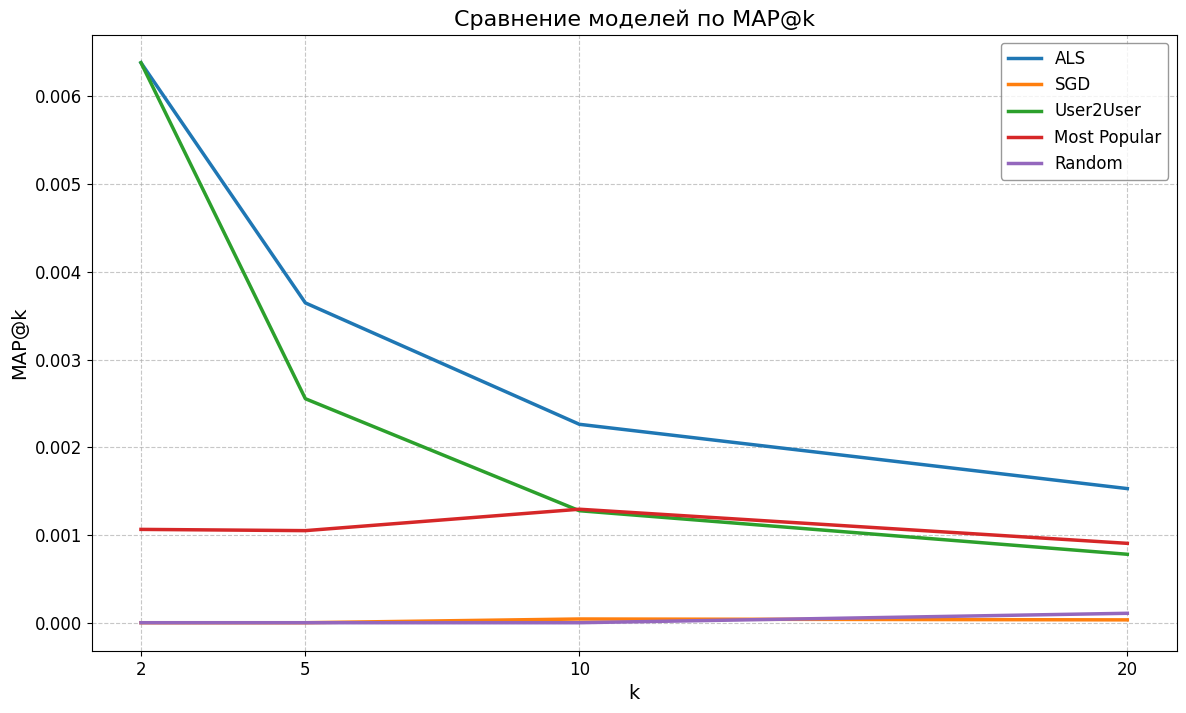

In [117]:
plt.figure(figsize=(14, 8))

for i, (name, scores) in enumerate(final_map_scores.items()):
    plt.plot(k_values, scores, linewidth=2.5,label=name)

plt.title('Сравнение моделей по MAP@k', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('MAP@k', fontsize=14)
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.show()

*Ура, с использованием ALS получилось сделать лучше, чем User2User. SGD получает немного более высокие результаты, чем рандомные рекомендации*

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [120]:
model = als_final

In [121]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [122]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.696268
5517,Варвара,['Би-2'],0.679600
2179,Восьмиклассница,['КИНО'],0.638466
2058,Последний герой,['КИНО'],0.630393
24284,Как на войне,['Агата Кристи'],0.625985
10282,Владивосток 2000,['Мумий Тролль'],0.618213
5515,Романс,['Сплин'],0.612424
5328,Fields Of Gold,['Sting'],0.605557
10307,Медведица,['Мумий Тролль'],0.604373


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [150]:
from scipy import sparse

class ImplicitALS(BaseModel):
    def __init__(self, ratings, dim=128, lamb = 0.01, alpha=15):
        super().__init__(ratings)
        self.dim = dim
        
        self.P = np.random.normal(scale=0.1, size=(self.n_users, dim))
        self.Q = np.random.normal(scale=0.1, size=(self.n_items, dim))
        
        self.lamb = 0.01
    
        self.alpha = 15
    
    def fit(self, num_iters=5):
        R_sparse = sparse.csr_matrix(self.R)
        
        for epoch in tqdm(range(num_iters)):
            self._update_user_factors(R_sparse)
            self._update_item_factors(R_sparse.T)
    
    def _update_user_factors(self, R_sparse):
    
        YtY = self.Q.T @ self.Q
        
        for u in range(self.n_users):
            items = R_sparse[u].nonzero()[1]
            if len(items) == 0:
                continue
                
            Y_u = self.Q[items]
            conf = 1 + self.alpha * np.ones(len(items))
            A = YtY + Y_u.T @ (np.diag(conf - 1) @ Y_u) + self.lamb * np.eye(self.dim)
            b = Y_u.T @ conf
            self.P[u] = np.linalg.solve(A, b)
    
    def _update_item_factors(self, R_sparse_t):
        XtX = self.P.T @ self.P
 
        for i in range(self.n_items):
            users = R_sparse_t[i].nonzero()[1]
            if len(users) == 0:
                continue
               
            X_i = self.P[users]
            conf = 1 + self.alpha * np.ones(len(users))
            
            A = XtX + X_i.T @ (np.diag(conf - 1) @ X_i) + self.lamb * np.eye(self.dim)
            b = X_i.T @ conf
            
            self.Q[i] = np.linalg.solve(A, b)
    
    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        
        return np.argsort(pred_rating)[::-1]

In [159]:
def objective_ials(trial: Trial, train_ratings, test_relevant, k_eval=2):
    np.random.seed(142)
    dim = trial.suggest_int('dim', 32, 256)
    lamb = trial.suggest_float('lamb', 0.001, 1.0, log=True)
    alpha = trial.suggest_float('alpha', 0.01, 100.0)
    #n_iters = trial.suggest_int('n_iters', 5, 10)
    
    model = ImplicitALS(train_ratings, dim=dim)
    model.lamb = lamb
    model.alpha = alpha
    model.fit(num_iters=5)

    preds = model.get_test_recommendations(k_eval)
    score = mapk(test_relevant, preds, k=k_eval)
    
    return score

In [160]:
study_ials = optuna.create_study(direction="maximize", study_name="ials_optimization")
study_ials.optimize(lambda trial: objective_ials(trial, train_ratings, test_relevant), n_trials=10)

print(f"Best parameters: {study_ials.best_params}")
print(f"Best score: {study_ials.best_value}")

[I 2025-06-09 17:35:31,029] A new study created in memory with name: no-name-12ba68c7-f6da-4c24-8d78-f13b48d88b28
100%|██████████| 5/5 [01:18<00:00, 15.77s/it]
/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
[I 2025-06-09 17:36:51,810] Trial 0 finished with value: 0.0010638297872340426 and parameters: {'dim': 148, 'lamb': 0.0017189117196349931, 'alpha': 29.664385666039834}. Best is trial 0 with value: 0.0010638297872340426.
100%|██████████| 5/5 [00:52<00:00, 10.42s/it]
[I 2025-06-09 17:37:45,493] Trial 1 finished with value: 0.005319148936170213 and parameters: {'dim': 87, 'lamb': 0.0012056995783878942, 'alpha': 53.16257346302411}. Best is trial 1 with value: 0.005319148936170213.
100%|██████████| 5/5 [02:19<00:00, 27.96s/it]
[I 2025-06-09 17:40:07,441] Trial 2 finished with value: 0.0 and parameters: {'dim

Best parameters: {'dim': 180, 'lamb': 0.1411459408267053, 'alpha': 60.57393900871847}
Best score: 0.007446808510638298


In [168]:
np.random.seed(142)

als_final = LatentFactorModel(train_ratings, dim=best_als_params['dim'], mode='als')
als_final.lamb = best_als_params['lamb']
als_final.fit(num_iters=10)

sgd_final = LatentFactorModel(train_ratings, dim=best_sgd_params['dim'], mode='sgd')
sgd_final.lamb = best_sgd_params['lamb']
sgd_final.lr = best_sgd_params['lr']
sgd_final.fit(num_iters=20)

np.random.seed(142)
best_ials_params = study_ials.best_params
implicit_als_final = ImplicitALS(train_ratings, dim=best_ials_params['dim'], lamb=best_ials_params['lamb'], alpha=best_ials_params['alpha'])
implicit_als_final.fit(num_iters=5)

user2user_final = User2User(train_ratings)
popular_final = Popular(train_ratings)
random_final = Random(train_ratings)

models_final = {
    "ALS": als_final,
    "SGD": sgd_final,
    "User2User": user2user_final,
    "Implicit ALS": implicit_als_final,
    "Most Popular": popular_final,
    "Random": random_final,
}

k_values = [2, 5, 10, 20]
final_map_scores = {name: [] for name in models_final.keys()}

for k in k_values:
    for name, model in models_final.items():
        preds = model.get_test_recommendations(k)
        score = mapk(test_relevant, preds, k=k)
        final_map_scores[name].append(score)

100%|██████████| 5/5 [01:36<00:00, 19.21s/it]
/var/folders/7_/sz_ftshd1b1b9sppxlm9vj9m0000gn/T/ipykernel_20816/2586408276.py:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


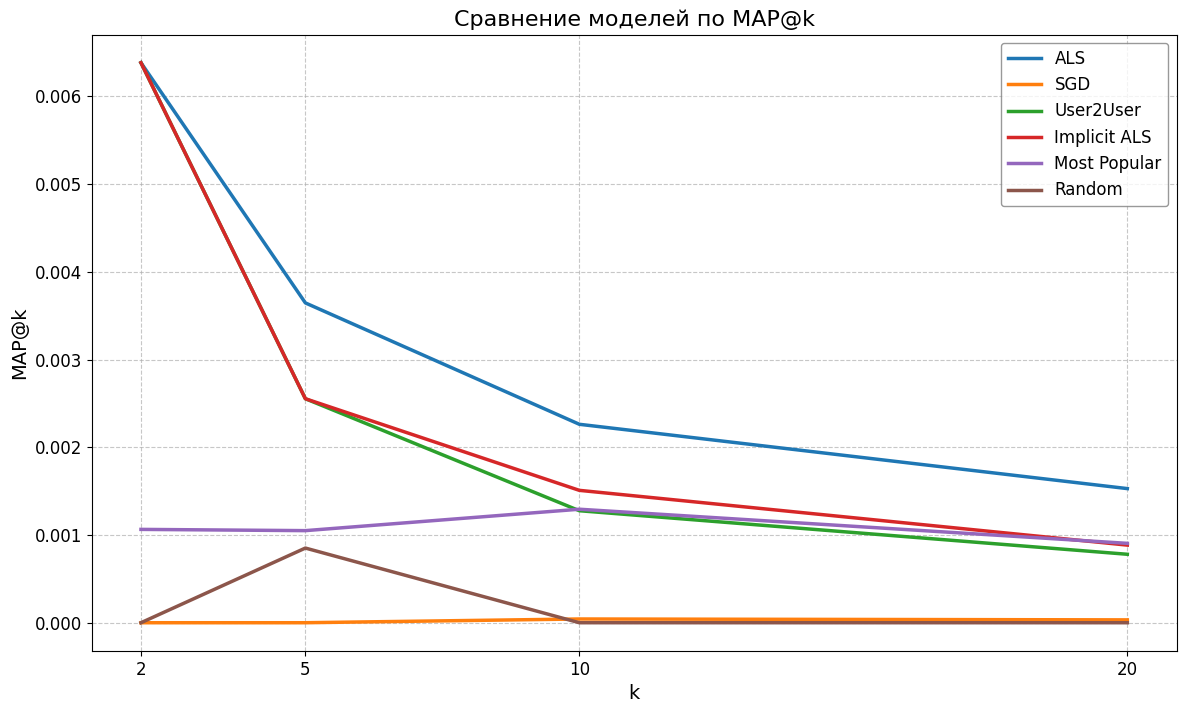

In [169]:
plt.figure(figsize=(14, 8))

for i, (name, scores) in enumerate(final_map_scores.items()):
    plt.plot(k_values, scores, linewidth=2.5,label=name)

plt.title('Сравнение моделей по MAP@k', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('MAP@k', fontsize=14)
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.show()

*Как можно заметить, не получилось сделать лучше, чем ALS, но результат выше, чем User2User. Интересно, что увеличение числа итераций при обучении может влиять в худшую сторону*

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [170]:
lfm_model = als_final
user2user_model = user2user_final

k = 100
candidates_dict = {}

for uid in tqdm(range(len(test_relevant))):
    lfm_recs = lfm_model.recommend(uid)[:k]
    u2u_recs = user2user_model.recommend(uid)[:k]
    combined_recs = np.unique(np.concatenate([lfm_recs, u2u_recs]))
    candidates_dict[uid] = combined_recs

100%|██████████| 235/235 [00:04<00:00, 56.50it/s]


**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪